# **Data Mining Project**

### Author: *Lorenzo Palloni*
### Table of Contents:
1. [Introduction](#1.-Introduction)
2. [Libraries](#2.-Libraries)
3. [EDA - Exploratory Data Analysis](#3.-EDA---Exploratory-Data-Analysis)  
    3.1 [Variables Visualization](#3.1-Variables-Visualization)  
4. [Preprocessing](#4.-Preprocessing)  
    4.1 [Handle High Correlations](#4.1-Handle-High-Correlations)  
    4.2 [Handle Duplicates](#4.2-Handle-Duplicates)  
    4.3 [Handle Missing Values](#4.3-Handle-Missing-Values)  
    4.4 [Handle Outliers](#4.4-Handle-Outliers)  
5. [Forecasting](#5.-Forecasting)  
    5.1 [Numeric Encoding](#5.1-Numeric-Encoding)  
    5.2 [One Hot Encoding](#5.2-One-Hot-Encoding)  
    5.3 [Parameters Validation](#5.3-Parameters-Validation)  
    5.4 [Fitting the Model](#5.4-Fitting-the-Model)  
6. [Interesting Remarks](#6.-Interesting-Remarks)  
7. [Clustering](#7.-Clustering)  
8. [Feedforward Neural Network](#8.-Feedforward-Neural-Network)  

# 1. Introduction

>**In this report is analyzed a dataset that regards some of the students of the *"Scuola di Scienze Matematiche, Fisiche e Naturali"* of the *"Università degli Studi di Firenze"*.**   
>**The structure of the report tries to mantain a certain sequencing rule, tough it could be more appriopriately represented by a tree structure.**

>**Firstly all the variables have been represented graphically, the dataset has been cleaned by checking high correlation variables and duplicate rows, imputing the missing values and handling the outliers.**  
>**Successively there is a forecasting part where a variable with missing values has been designed as target variable and than, through the Decision Tree model the missing values has been managed.**  
>**When the dataset has been fully cleaned, the K-Means algorithm has been applied to the dataset.**

>**In the end, a Feedforward Neural Network has been applied for the same task of the Decision Tree, in order to have a comparison of both methods regarding the accuracy of the predictions.**

# 2. Libraries

In [1]:
%matplotlib inline

import pandas as pd  # For dataset management
import numpy as np  # For arrays management
from IPython.display import display  # For multiple html outputs of the cells
import matplotlib.pyplot as plt  # To plot graphs
import seaborn as sns  # For plotting in a fancy way
from sklearn.model_selection import train_test_split  # To split the dataset
from sklearn.tree import DecisionTreeRegressor  # For Decision Tree model algorithm

from src.constants.paths import RAW, OUTPUTS, PLOTS, INTERIM, PROCESSED  # For some constant of the project
from src.utilities import myUtils  # For some utility functions
from src.utilities.Encoder import Encoder  # To encode the categorical variables

from sklearn.preprocessing import StandardScaler  # For column-wise standardization of the dataset
from sklearn.cluster import KMeans  # For K-Means algorithm

from quicknn import QuickNN  # For my sklearn-like implementation of a neural network model (wrapping tensorflow)
import tensorflow as tf  # For tf.train.AdamOptimizer training function

import warnings
warnings.simplefilter("ignore")  # To remove warnings

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)  # Set the seed number for the RNG

# 3. EDA - Exploratory Data Analysis

>**Reading the dataset.**

In [2]:
data_filename = RAW / 'primo_anno_coorti_2010_2016_per_cds_della_scuola_di_smfn.csv'
data = pd.read_csv(data_filename)

>**The dimensionality of the dataset.**

In [3]:
n_rows, n_cols = data.shape
print(">>> Number of observations: ", n_rows, "\n>>> Number of variables:      ", n_cols)

>>> Number of observations:  1232 
>>> Number of variables:       11


>**Showing the first 5 observations of the dataset.**

In [4]:
data.head()

CdS  Coorte Genere  Voto_test  Crediti_convoto  Crediti_totali  \
0  CdS1    2010      M       22.0               27              57   
1  CdS1    2010      M       17.0                9               9   
2  CdS1    2010      F       13.0               21              30   
3  CdS1    2010      F       19.0               39              51   
4  CdS1    2010      F       17.0               45              54   

   Voto_medio Scuola_provenienza Esame_Matematica  Voto_Matematica  \
0          24                 LC  EsameMatematica             20.0   
1          24                 LS  EsameMatematica             20.0   
2          20                 LS  EsameMatematica             25.0   
3          26                 LS  EsameMatematica             30.0   
4          23                 TC  EsameMatematica             24.0   

   Crediti_Matematica  
0                12.0  
1                12.0  
2                12.0  
3                12.0  
4                12.0

>**In this report *'object' type* and *categorical* terms are considered coincident.**  
>**Here is checked if all variables of type 'object' are actually categorical variables.**

In [5]:
display(data.select_dtypes(include='object').head())
print(">>> First 5 rows of the dataset, selecting only the 'object' type variables.")

CdS Genere Scuola_provenienza Esame_Matematica
0  CdS1      M                 LC  EsameMatematica
1  CdS1      M                 LS  EsameMatematica
2  CdS1      F                 LS  EsameMatematica
3  CdS1      F                 LS  EsameMatematica
4  CdS1      F                 TC  EsameMatematica

>>> First 5 rows of the dataset, selecting only the 'object' type variables.


>**Checking if all variables of numeric type are actually ordinal variables.  
There are the variables 'Coorte' and 'Crediti_Matematica' that might have be cast to 'object' type.   
Depends on their unique value counts.**

In [6]:
display(data.select_dtypes(include='number').head())
print(">>> Counts of the unique values of variable 'Coorte': ")
display(pd.DataFrame(data["Coorte"].value_counts()).T)
print(">>> Counts of the unique values of variable 'Crediti_Matematica': ")
display(pd.DataFrame(data["Crediti_Matematica"].value_counts()).T)
print(">>> They need to be cast to 'object' type.")

Coorte  Voto_test  Crediti_convoto  Crediti_totali  Voto_medio  \
0    2010       22.0               27              57          24   
1    2010       17.0                9               9          24   
2    2010       13.0               21              30          20   
3    2010       19.0               39              51          26   
4    2010       17.0               45              54          23   

   Voto_Matematica  Crediti_Matematica  
0             20.0                12.0  
1             20.0                12.0  
2             25.0                12.0  
3             30.0                12.0  
4             24.0                12.0

>>> Counts of the unique values of variable 'Coorte': 


2013  2014  2016  2015  2010  2012  2011
Coorte   197   193   188   169   163   161   161

>>> Counts of the unique values of variable 'Crediti_Matematica': 


12.0  15.0  9.0   3.0   6.0   1.0 
Crediti_Matematica   695   271     2     1     1     1

>>> They need to be cast to 'object' type.


In [7]:
var_names_to_cast_from_int64_to_object = ["Coorte", "Crediti_Matematica"]

# file = open(INTERIM / "var_names_to_cast_from_int64_to_object.txt", 'w+')
# file.write(", ".join(var_name for var_name in var_names_to_cast_from_int64_to_object))
# file.close()
# f = open(INTERIM / "var_names_to_cast_from_int64_to_object.txt", 'r')
# var_names_to_cast_from_int64_to_object = "".join(char for char in f.read()).split(", ")
# f.close()

for var_name in var_names_to_cast_from_int64_to_object:
    data[var_name] = data[var_name].astype('object')
print(">>> Done. The variables 'Coorte' and 'Crediti_Matemcatica' are casted to 'object' type.")

>>> Done. The variables 'Coorte' and 'Crediti_Matemcatica' are casted to 'object' type.


>**Checking missing values in order to better visualize the variables in [3.1 Variables Visualization](#3.1-Variables-Visualization) paragraph.**  

In [8]:
display(pd.DataFrame(data.select_dtypes(include='object').isnull().sum(), columns=["Number of missing values"]).T)
print('\n')
print(">>> In the case of categorical variables it is necessary to assign (for now) the value 'NA' to each missing value.")
display(pd.DataFrame(data.select_dtypes(include='number').isnull().sum(), columns=["Number of missing values"]).T)
print('\n')
print(">>> On other hand for numerical variables case, is possible to visualize a ratio of the missing values on the total of observation.")

CdS  Coorte  Genere  Scuola_provenienza  \
Number of missing values    0       0       0                  23   

                          Esame_Matematica  Crediti_Matematica  
Number of missing values               261                 261



>>> In the case of categorical variables it is necessary to assign (for now) the value 'NA' to each missing value.


Voto_test  Crediti_convoto  Crediti_totali  \
Number of missing values          0                0               0   

                          Voto_medio  Voto_Matematica  
Number of missing values           0              261



>>> On other hand for numerical variables case, is possible to visualize a ratio of the missing values on the total of observation.


In [9]:
cat_vars_with_na = [name for name, _ in zip(data.select_dtypes(include='object').isnull().sum().index.tolist(),
                                            data.select_dtypes(include='object').isnull().sum().values) if _ > 0]
for var_name in cat_vars_with_na:
    data[var_name].fillna('NA', inplace=True)
print(">>> The value 'NA' is assigned to each missing value of each categorical variable.")

>>> The value 'NA' is assigned to each missing value of each categorical variable.


In [10]:
num_vars_with_na = [name for name, _ in zip(data.select_dtypes(include='number').isnull().sum().index.tolist(),
                                            data.select_dtypes(include='number').isnull().sum().values) if _ > 0]
for var_name in num_vars_with_na:
    print(">>> Missing value ratio for variable '{0}': {1:.2f}".format(var_name, data[var_name].isnull().sum() / n_rows))

>>> Missing value ratio for variable 'Voto_Matematica': 0.21


## 3.1 Variables Visualization

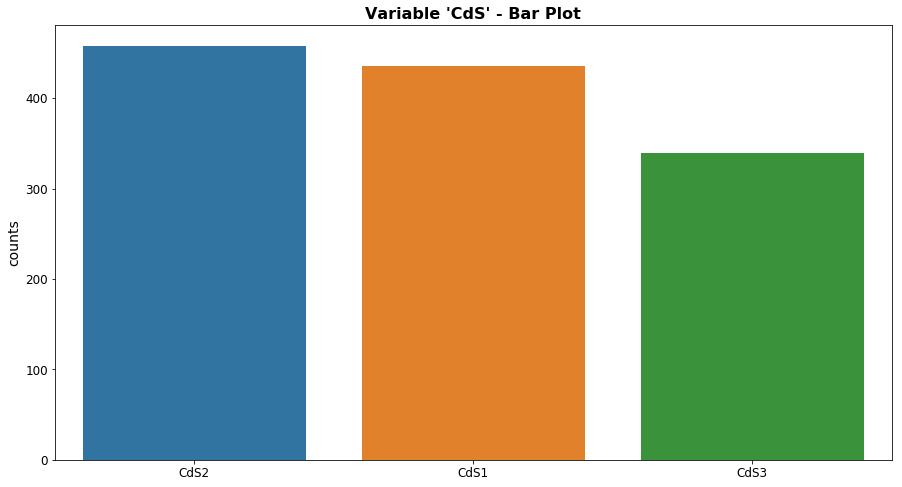

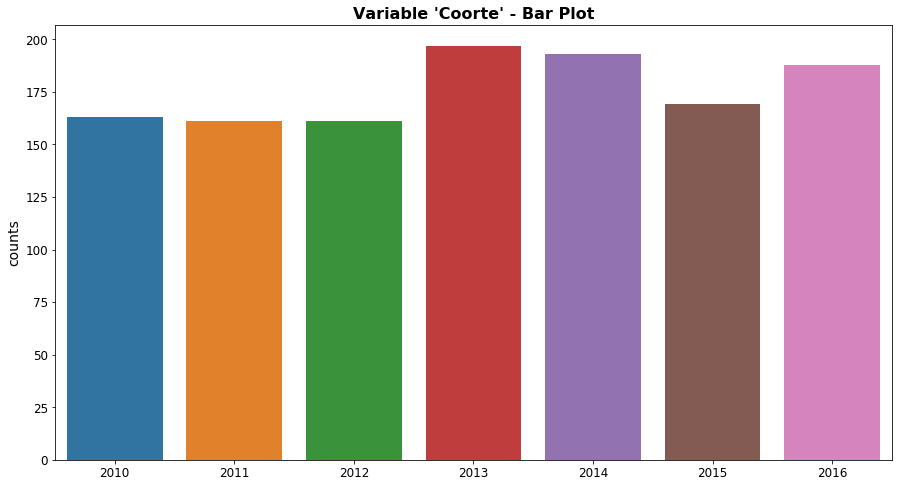

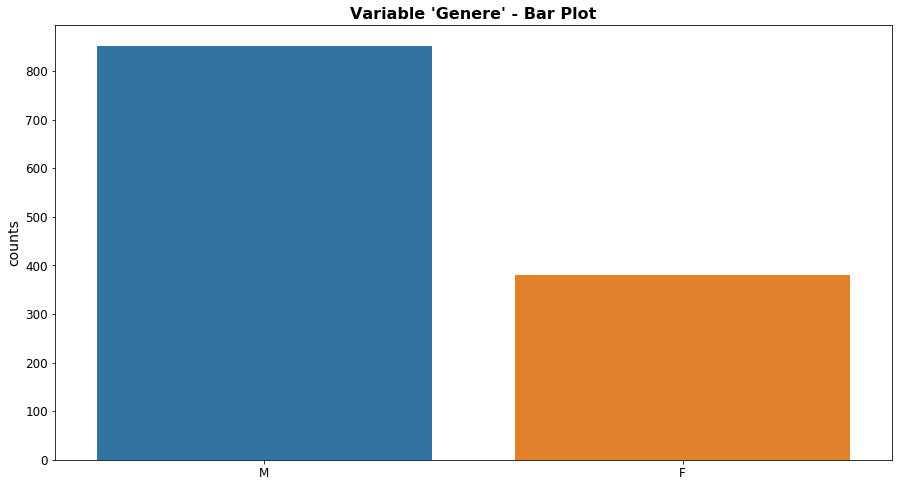

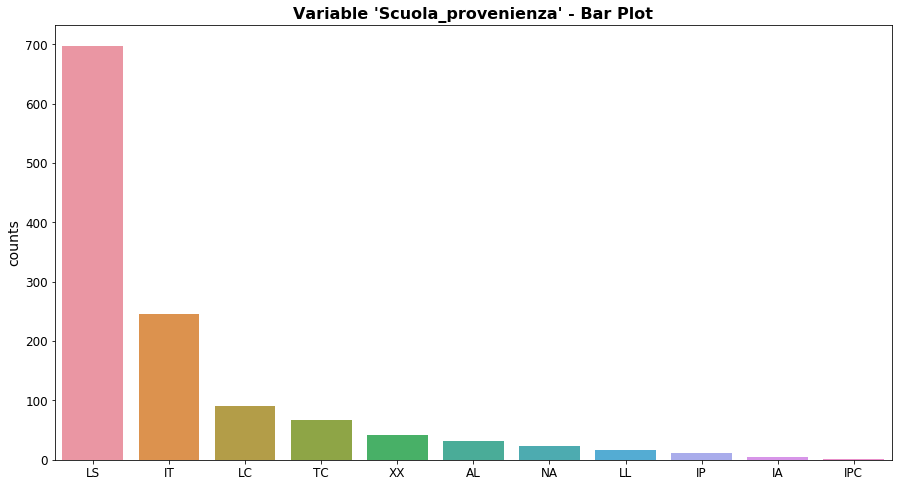

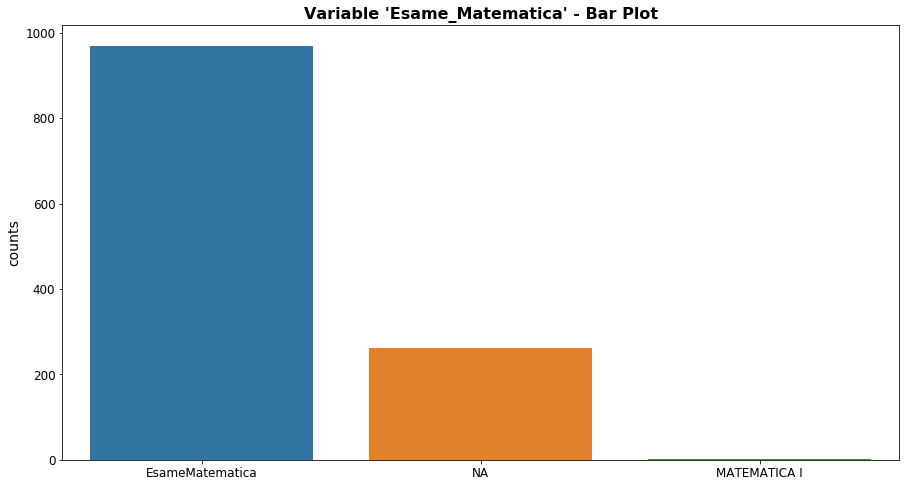

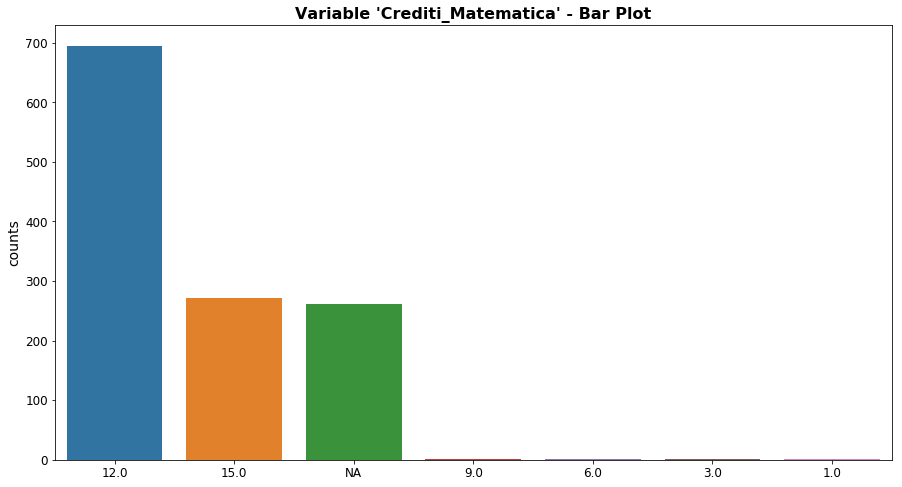

In [11]:
for var_name in data.select_dtypes(include='object').columns.tolist():
#     myUtils.bar_plot(data[var_name], save_path=PLOTS / "{0}_bar_plot.png".format(var_name), title="Variable '{0}' - Bar Plot".format(var_name))
    myUtils.bar_plot(data[var_name], title="Variable '{0}' - Bar Plot".format(var_name))

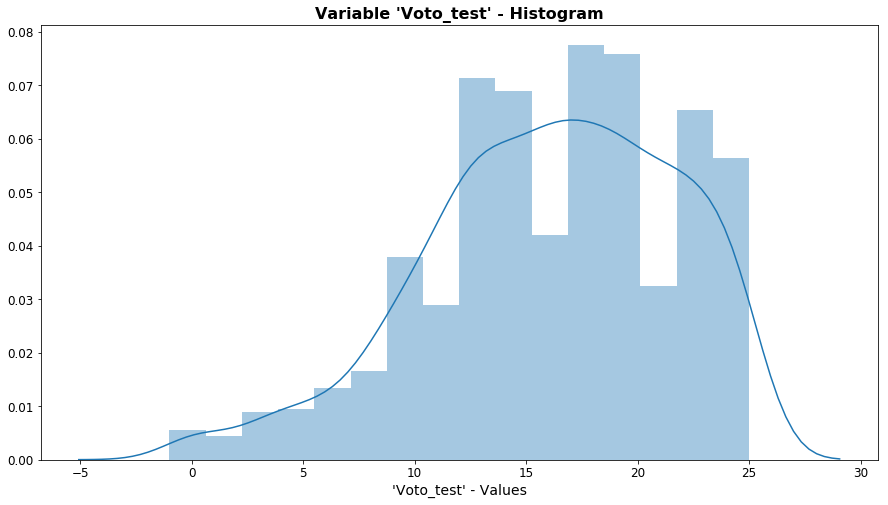

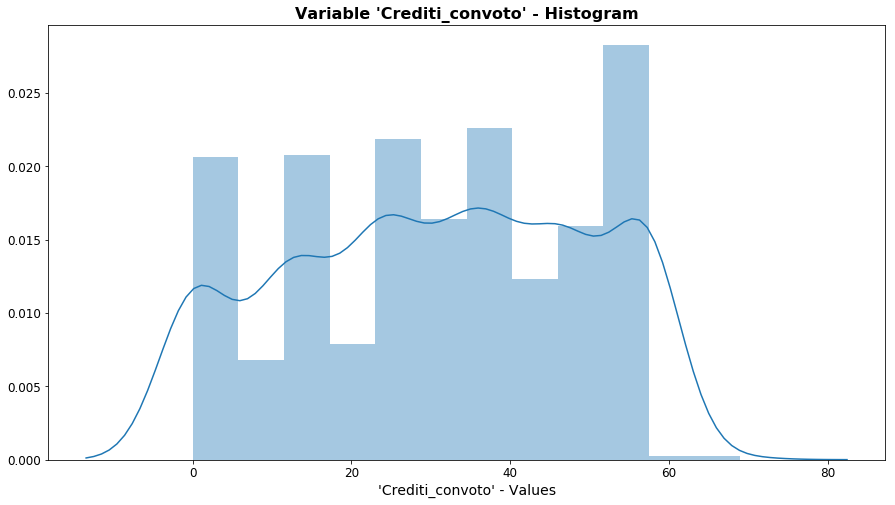

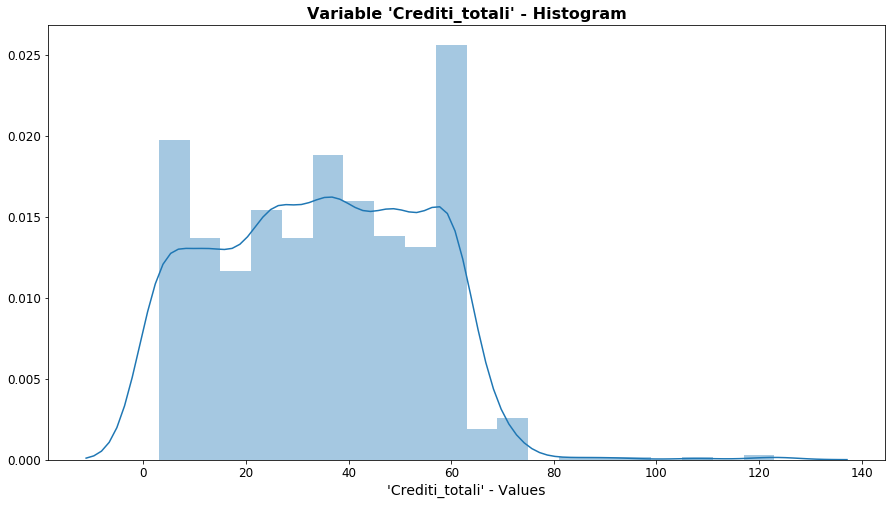

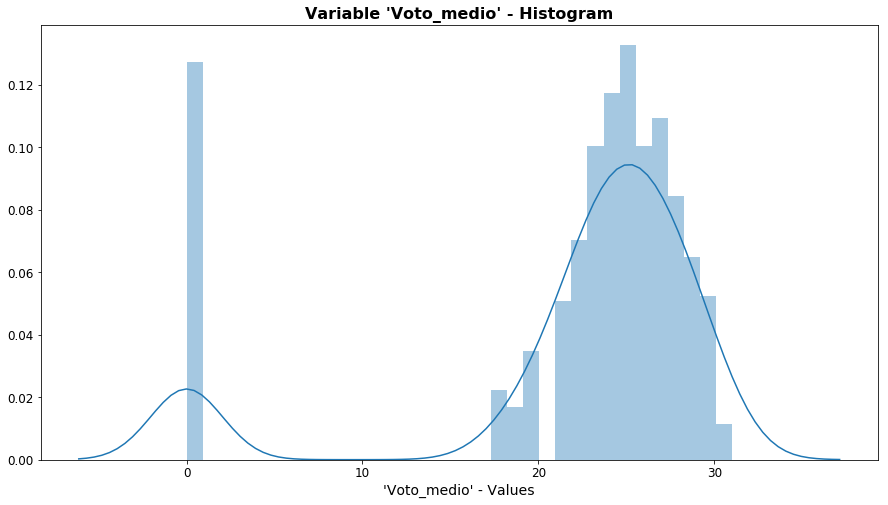

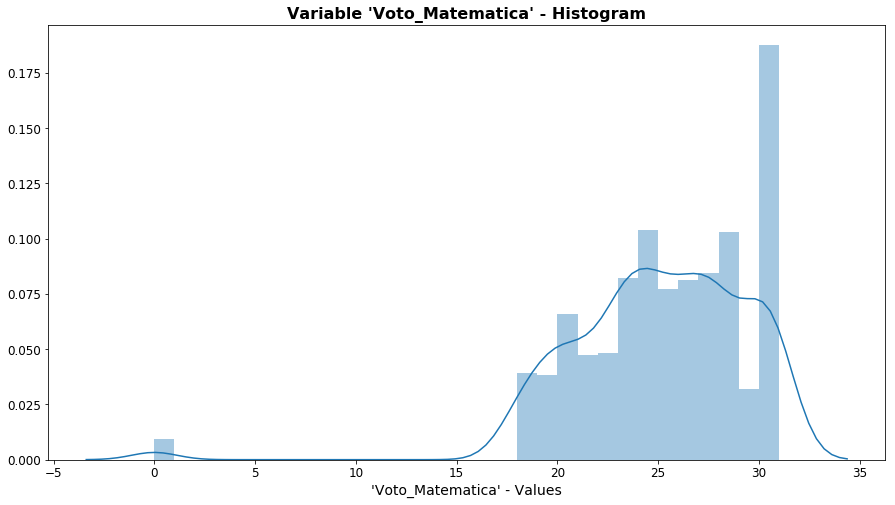

In [12]:
for var_name in data.select_dtypes(include='number').columns.tolist():
    myUtils.hist_plot(data[var_name], title="Variable '{0}' - Histogram".format(var_name))
#     myUtils.hist_plot(data[var_name], save_path=PLOTS / "{0}_hist.png".format(var_name), title="Variable '{0}' - Histogram".format(var_name))

>**Correlation Matrix of the dataset**

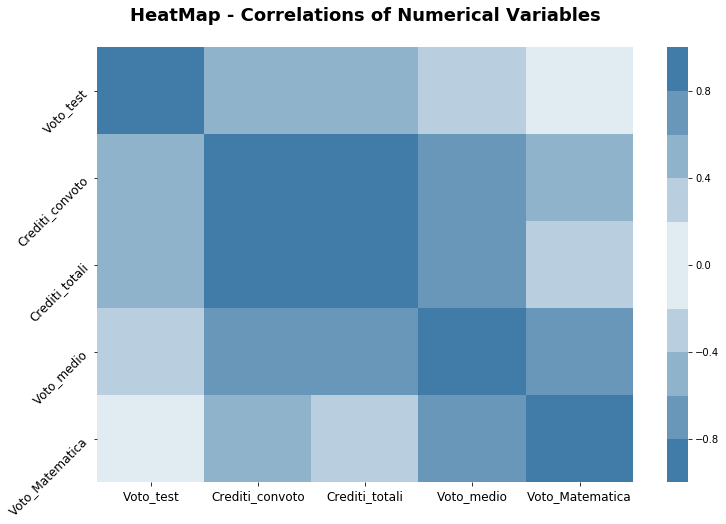



>>> From the heatmap plotted above, an high correlation between 'Crediti_totali' and 'Crediti_convoto' figures out.


In [13]:
corr_matrix = data.select_dtypes(include="number").corr()

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("HeatMap - Correlations of Numerical Variables\n", size=18, fontweight='bold')
sns.heatmap(corr_matrix, ax=ax, vmin=-1, vmax=1, cmap=sns.diverging_palette(240, 240, n=10, center="light"))
plt.yticks(rotation=45)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(14)
ax.xaxis.label.set_fontsize(14)
# fig.savefig(str(PLOTS / "heatmap_numerical_correlation.png"), format="png")
plt.show()
print('\n')
print(">>> From the heatmap plotted above, an high correlation between 'Crediti_totali' and 'Crediti_convoto' figures out.")

# 4. Preprocessing

## 4.1 Handle High Correlations
>**Deepening on the relashionship between 'Crediti_totali' and 'Crediti_convoto'**

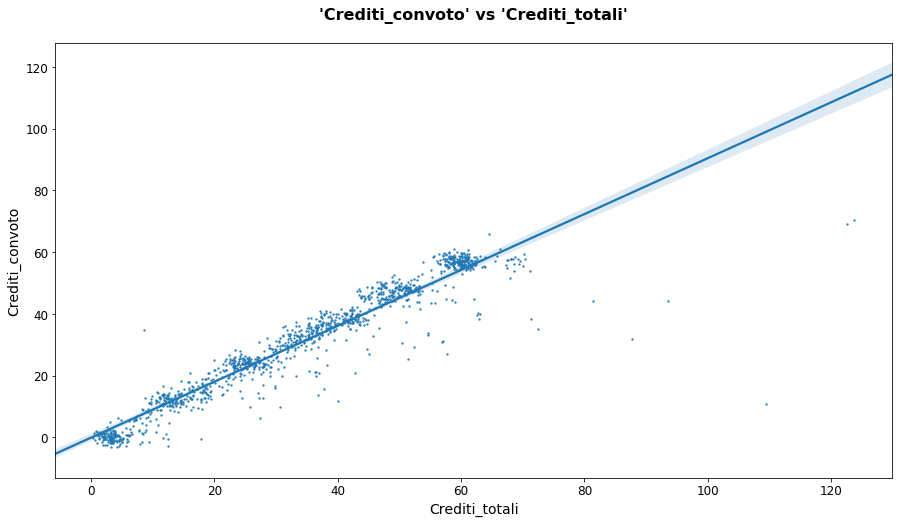



>>> The linear correlation coefficient between the two variables is: 0.9554560871283462
>>> Is worth to drop the variable 'Crediti_totali' since between the two has more extreme values.
>>> Number of variables updated from 11 to 10.


In [14]:
jitter1 = np.random.normal(scale=1.5, size=n_rows)
jitter2 = np.random.normal(scale=1.5, size=n_rows)
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(x=data["Crediti_totali"] + jitter1,
            y=data["Crediti_convoto"] + jitter2,
            marker='o',
            scatter_kws={'s':2},
            ax=ax)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(14)
ax.xaxis.label.set_fontsize(14)
ax.title.set_text("'Crediti_convoto' vs 'Crediti_totali'\n")
ax.title.set_fontsize(16)
ax.title.set_fontweight('bold')
# plt.savefig(str(PLOTS / "crediti_convoto_vs_crediti_totali.png"), format='png')
plt.show()
print('\n')
print(">>> The linear correlation coefficient between the two variables is: {0}".format(data[["Crediti_convoto", "Crediti_totali"]].corr().iloc[1, 0]))
data.drop(columns=["Crediti_totali"], inplace=True)
print(">>> Is worth to drop the variable 'Crediti_totali' since between the two has more extreme values.")
print(">>> Number of variables updated from {0} to {1}.".format(n_cols, data.shape[1]))
n_cols = data.shape[1]

## 4.2 Handle Duplicates

>**In the next cell is shown that some of the observations are duplicated.**  
>**The choices are two here:**   
>
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- keep them;**  
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- drop them.**

In [15]:
duplicated_idx = data.duplicated(keep=False).values
display(data.iloc[duplicated_idx, :].head(6))
data.drop(data.index[duplicated_idx], axis=0, inplace=True)
print('\n')
print(">>> The duplicates are dropped.")
print(">>> This because each second occurrence occurs just after the first ones in terms of index and probably it is attributable to human error.")
data.reset_index(drop=True, inplace=True)
print(">>> Index reset because dropping rows causes mess in the index of the dataset.")
n_rows_temp = data.shape[0]
print(">>> Number of observations updated from {0} to {1}.".format(n_rows, n_rows_temp))
n_rows = n_rows_temp

CdS Coorte Genere  Voto_test  Crediti_convoto  Voto_medio  \
20   CdS1   2010      M       20.0               57          28   
26   CdS1   2010      M       20.0               57          28   
86   CdS1   2011      M       25.0               57          28   
100  CdS1   2011      M       25.0               57          28   
202  CdS1   2013      M       14.0                6          25   
204  CdS1   2013      M       14.0                6          25   

    Scuola_provenienza Esame_Matematica  Voto_Matematica Crediti_Matematica  
20                  LS  EsameMatematica             26.0                 12  
26                  LS  EsameMatematica             26.0                 12  
86                  LS  EsameMatematica             31.0                 12  
100                 LS  EsameMatematica             31.0                 12  
202                 IT               NA              NaN                 NA  
204                 IT               NA              NaN                 NA



>>> The duplicates are dropped.
>>> This because each second occurrence occurs just after the first ones in terms of index and probably it is attributable to human error.
>>> Index reset because dropping rows causes mess in the index of the dataset.
>>> Number of observations updated from 1232 to 1212.


## 4.3 Handle Missing Values

>**A recall to variables that have missing values**

In [16]:
for var_name in cat_vars_with_na:
    print(">>> Categorical variable that have the value 'NA' in place of missing values: '{0}'.".format(var_name))
for var_name in num_vars_with_na:
    print(">>> Numeric variable that have missing values: '{0}'.".format(var_name))

>>> Categorical variable that have the value 'NA' in place of missing values: 'Scuola_provenienza'.
>>> Categorical variable that have the value 'NA' in place of missing values: 'Esame_Matematica'.
>>> Categorical variable that have the value 'NA' in place of missing values: 'Crediti_Matematica'.
>>> Numeric variable that have missing values: 'Voto_Matematica'.


>**The following cell is an observation, it is not required to understand the remaining analysis.**

>**Except for the variable 'Scuola_provenienza', the other variables with missing values have the 'NA' values in the same observations, for each observation.  
In a row of the dataset where e.g. 'Voto_Matematica' is missing, necessarily either 'Esame_Matematica' and 'Crediti_Matematica' have 'NA' values.**

In [17]:
voto_matematica_na_idx = data["Voto_Matematica"].isnull().values
data_reference = data.iloc[voto_matematica_na_idx, :]
print(">>> Number of missing values of the variable 'Voto_Matematica': ", data_reference.shape[0])
esame_matematica_na_idx_ref = (data_reference["Esame_Matematica"] == 'NA').values
print(">>> Number of rows that have missing values for the variables 'Voto_Matematica' and 'Esame_Matematica' at the same time: ",
      data_reference.iloc[esame_matematica_na_idx_ref, :].shape[0])
print(">>> Number of 'NA' values of the variable 'Esame_Matematica': ", (data["Esame_Matematica"] == 'NA').sum())
crediti_matematica_na_idx_ref = (data_reference["Crediti_Matematica"] == 'NA').values
print(">>> Number of rows that have missing values for the variables 'Voto_Matematica' and 'Crediti_Matematica' at the same time: ",
      data_reference.iloc[crediti_matematica_na_idx_ref, :].shape[0])
print(">>> Number of 'NA' values of the variable 'Crediti_Matematica': ", (data["Crediti_Matematica"] == 'NA').sum())
scuola_provenienza_na_idx_ref = (data_reference["Scuola_provenienza"] == 'NA').values
print(">>> Number of rows that have missing values for the variables 'Voto_Matematica' and 'Scuola_provenienza' at the same time: ",
     data_reference.iloc[scuola_provenienza_na_idx_ref, :].shape[0])
print(">>> Number of 'NA' values of variable 'Scuola_provenienza': ", (data["Scuola_provenienza"] == 'NA').sum())

del esame_matematica_na_idx_ref 
del crediti_matematica_na_idx_ref
del scuola_provenienza_na_idx_ref

>>> Number of missing values of the variable 'Voto_Matematica':  253
>>> Number of rows that have missing values for the variables 'Voto_Matematica' and 'Esame_Matematica' at the same time:  253
>>> Number of 'NA' values of the variable 'Esame_Matematica':  253
>>> Number of rows that have missing values for the variables 'Voto_Matematica' and 'Crediti_Matematica' at the same time:  253
>>> Number of 'NA' values of the variable 'Crediti_Matematica':  253
>>> Number of rows that have missing values for the variables 'Voto_Matematica' and 'Scuola_provenienza' at the same time:  6
>>> Number of 'NA' values of variable 'Scuola_provenienza':  23


>**Since the [distributions](#3.1-Variables-Visualization) of the variables 'Esame_Matematica' and 'Crediti_Matematica', an appropriate way to handle the imputation might be to leave the value 'NA' in order to preserve the information about the missing values, i.e. the fact that the missing values are missing Not At Random (NAR) is assumed in both the variables.**

In [18]:
data['Esame_Matematica'][data['Esame_Matematica'] == 'NA'] = 'NAR_esame_matematica'
data['Crediti_Matematica'][data['Crediti_Matematica'] == 'NA'] = 'NAR_crediti_matematica'
print(">>> 'NA' values of the variables 'Esame_Matematica' and 'Crediti_Matematica' updated with the value 'NAR_variable_name'.")

>>> 'NA' values of the variables 'Esame_Matematica' and 'Crediti_Matematica' updated with the value 'NAR_variable_name'.


>**Since the [distribution](#3.1-Variables-Visualization)  of the variable 'Scuola_provenienza' and taking into account that there are few missing values in this variable, a reasonable way to handle the 'NA' value here is to impute the mode value.**

In [19]:
scuola_provenienza_mode_value = data["Scuola_provenienza"].value_counts().index[0]
print(">>> Mode value of the variable 'Scuola_provenienza': '{}'".format(scuola_provenienza_mode_value))
scuola_provenienza_na_idx = (data["Scuola_provenienza"] == 'NA').values
data["Scuola_provenienza"].iloc[scuola_provenienza_na_idx] = scuola_provenienza_mode_value
print(">>> Mode value of the variable 'Scuola_provenienza' imputed to the missing values.")

>>> Mode value of the variable 'Scuola_provenienza': 'LS'
>>> Mode value of the variable 'Scuola_provenienza' imputed to the missing values.


>**Regarding the continuous variable 'Voto_Matematica', a couple of ways to impute the missing values have been considered here:**  
>
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- with the mean;**  
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- with the zero value.**

<a id=objective> </a>
>**Another way might be to predict the variable based on the information of the other variables. In order to accomplish this goal in [5. Forecasting](#5.-Forecasting) section,  a Decision Tree model will be used.**

## 4.4 Handle Outliers

>**Observing the plots of the [distributions](#visualization) of all variables, it is possible to figure out that the variables 'Esame_Matematica' and 'Crediti_Matematica' have outliers that must be handle.**

In [20]:
display(pd.DataFrame(data["Esame_Matematica"].value_counts().values,
                     index=data["Esame_Matematica"].value_counts().index,
                     columns=["Esame_Matematica"]).T.style.highlight_min(axis=1))
print(">>> The variable 'Esame_Matematica' has only one occurrence of the value 'MATEMATICA I'")
display(pd.DataFrame(data["Crediti_Matematica"].value_counts().values,
                     index=data["Crediti_Matematica"].value_counts().index,
                     columns=["Crediti_Matematica"]).T.style.apply(myUtils.highlight_esame_matematica_outliers))
print(">>> The variable 'Crediti_Matematica' has only 5 occurrences below the value 9.0.")

>>> The variable 'Esame_Matematica' has only one occurrence of the value 'MATEMATICA I'


>>> The variable 'Crediti_Matematica' has only 5 occurrences below the value 9.0.


In [21]:
display(data[data["Esame_Matematica"] == 'MATEMATICA I'])
print(">>> The only observation where the variable 'Esame_Matematica' assumes the value equal to 'MATEMATICA I'.")
display(pd.DataFrame(data.mean(axis=0).values,
                     index=data.mean(axis=0).index.tolist(),
                     columns=["Average value"]).T)
print(">>> Comparing the observation with the average of all observations, it seems that in the other variables it doesn't assume weird values.")
data["Esame_Matematica"].iloc[(data["Esame_Matematica"] == 'MATEMATICA I').values] = data["Esame_Matematica"].value_counts().index[0]
display(pd.DataFrame(data["Esame_Matematica"].value_counts().values,
                     index=data["Esame_Matematica"].value_counts().index,
                     columns=["Esame_Matematica"]).T)
print(">>> Since it is only a single row, the mode value of the variable 'Esame_Matematica' (that is '{0}') is imputed to the missing value.".format(data["Esame_Matematica"].value_counts().index[0]))

CdS Coorte Genere  Voto_test  Crediti_convoto  Voto_medio  \
109  CdS1   2011      F       13.0               36          26   

    Scuola_provenienza Esame_Matematica  Voto_Matematica Crediti_Matematica  
109                 LC     MATEMATICA I              0.0                  9

>>> The only observation where the variable 'Esame_Matematica' assumes the value equal to 'MATEMATICA I'.


Voto_test  Crediti_convoto  Voto_medio  Voto_Matematica
Average value  16.042492        30.735149    22.14769        24.996872

>>> Comparing the observation with the average of all observations, it seems that in the other variables it doesn't assume weird values.


EsameMatematica  NAR_esame_matematica
Esame_Matematica              959                   253

>>> Since it is only a single row, the mode value of the variable 'Esame_Matematica' (that is 'EsameMatematica') is imputed to the missing value.


In [22]:
crediti_matematica_outliers_values = data.Crediti_Matematica.value_counts()[data.Crediti_Matematica.value_counts() < 5].index.tolist()
crit = [True if b in crediti_matematica_outliers_values else False for b in data.Crediti_Matematica.values]
display(data[crit])
print(">>> The other variables tied to the outliers of the variable 'Crediti_Matematica' doesn't assume weird values.")
crediti_matematica_mode_value = data["Crediti_Matematica"].value_counts().index.tolist()[0]
data["Crediti_Matematica"][crit] = crediti_matematica_mode_value
display(pd.DataFrame(data["Crediti_Matematica"].value_counts().values,
                     index=data["Crediti_Matematica"].value_counts().index,
                     columns=["Crediti_Matematica"]).T)
print(">>> Also in this case the mode (that is '{0}') is imputed to the missing values of the variable 'Crediti_Matematica'.".format(crediti_matematica_mode_value))

CdS Coorte Genere  Voto_test  Crediti_convoto  Voto_medio  \
109  CdS1   2011      F       13.0               36          26   
180  CdS1   2012      M       22.0               69          28   
186  CdS1   2013      M       15.0               24          20   
901  CdS3   2010      M       17.0               21          23   
919  CdS3   2010      F       17.0               18          19   

    Scuola_provenienza Esame_Matematica  Voto_Matematica Crediti_Matematica  
109                 LC  EsameMatematica              0.0                  9  
180                 LS  EsameMatematica             25.0                  1  
186                 IT  EsameMatematica              0.0                  9  
901                 LS  EsameMatematica             23.0                  6  
919                 LS  EsameMatematica             19.0                  3

>>> The other variables tied to the outliers of the variable 'Crediti_Matematica' doesn't assume weird values.


12.0  15.0  NAR_crediti_matematica
Crediti_Matematica   692   267                     253

>>> Also in this case the mode (that is '12.0') is imputed to the missing values of the variable 'Crediti_Matematica'.


>**Ensuring that all the categorical variables that had numeric values (except for the 'NAR_var_name' values), now have all 'str' type values.**

In [23]:
for var_name in var_names_to_cast_from_int64_to_object:
    data[var_name] = data[var_name].astype('str')
    print(">>> The values of the variable '{0}' are actually all 'str' type.".format(var_name))

>>> The values of the variable 'Coorte' are actually all 'str' type.
>>> The values of the variable 'Crediti_Matematica' are actually all 'str' type.


In [24]:
# data.to_csv(INTERIM / "preEncoding.csv", index=None)  # Save the dataset ready to encoding.
# data = pd.read_csv(INTERIM / "preEncoding.csv")  # Import the dataset ready to encoding.

# 5. Forecasting

>**The dataset is almost ready to feed the trainining of the Decision Tree model, but before it is necessary to encode the 'object' variables into numeric. To accomplish this task the [Encoder](../src/utilities/Encoder.py) class is utilized. This home-made class can perform on a pd.DataFrame object:**  
>
>**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- [numeric encoding](#5.1-Numeric-Encoding);**  
>**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- [One-Hot encoding](#5.2-One-Hot-Encoding).**  

>**To decide which technique to use, it is necessary to compare the results of the prediction model with both the techniques.**

## 5.1 Numeric Encoding

>**Simply for each 'object' type variable each unique value is encoded into a number from 0 to the n - 1, where:**  
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- n is the number of unique values of the variable;**  
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- the order in which the values are encoded is lexicographic.**  
>**Then each value of that variable is encoded.**

In [25]:
# Uncomment and run this cell (and comment the One-Hot encoding cell) in order to encode the dataset with numeric encoding.

encoder = Encoder()
data = encoder.fit_encode(data, drop=True)
print(">>> Dataset encoded with numeric encoding.")

>>> Dataset encoded with numeric encoding.


In [26]:
# # Uncomment and run this cell to decode the dataset

# data = encoder.decode(drop=True)
# print(">>> Dataset decoded.")

## 5.2 One-Hot Encoding

>**Another way to encode the dataset is through the One-Hot-Encoding technique, that consists in, for each categorical variable, adding as many dummy variables to the dataset as many are the unique values of an 'object' type variable. A dummy variable is a variable that can assume only values 0(absence) and 1(presence).**

In [27]:
# # Uncomment and run this cell (and comment the numeric encoding cell) in order to encode the dataset with One-Hot encoding.

# encoder = Encoder()
# data = encoder.fit_one_hot_encode(data, drop=True)  # To One-Hot encode the dataset
# print(">>> Dataset encoded with One-Hot encoding technique.")

# n_cols_temp = len(data.columns.tolist())
# print(">>> Number of columns updated from {0} to {1}.".format(n_cols, n_cols_temp))
# n_cols = n_cols_temp

>**Showing the first 5 rows of the encoded dataset.**

In [28]:
data.head()

Voto_test  Crediti_convoto  Voto_medio  Voto_Matematica  CdS_encoded  \
0       22.0               27          24             20.0            0   
1       17.0                9          24             20.0            0   
2       13.0               21          20             25.0            0   
3       19.0               39          26             30.0            0   
4       17.0               45          23             24.0            0   

   Coorte_encoded  Genere_encoded  Scuola_provenienza_encoded  \
0               0               1                           5   
1               0               1                           7   
2               0               0                           7   
3               0               0                           7   
4               0               0                           8   

   Esame_Matematica_encoded  Crediti_Matematica_encoded  
0                         0                           0  
1                         0                           0  
2                         0                           0  
3                         0                           0  
4                         0                           0

## 5.3 Parameters Validation
>**The Decision Tree model will be trained on the rows of the dataset where the variable 'Voto_Matematica' has missing values.**

>**To validate the results of the model it is necessary to split the training set into two subset: a new training set (obtained with random sampling from original training set) and a validation set.**

In [29]:
test_idx = data["Voto_Matematica"].isnull()
train_idx = ~test_idx
X_train, y_train = data.drop(columns=["Voto_Matematica"])[train_idx], data["Voto_Matematica"][train_idx]
X_test = data.drop(columns=["Voto_Matematica"])[test_idx]
print(">>> Dataset splitted into training_set and test_set based on the rows where 'Voto_Matematica' has missing values.")

>>> Dataset splitted into training_set and test_set based on the rows where 'Voto_Matematica' has missing values.


In [30]:
# X_train.to_csv(INTERIM / 'X_train.csv', index=None)
# X_test.to_csv(INTERIM / 'X_test.csv', index=None)
# pd.DataFrame(y_train).to_csv(INTERIM / 'y_train.csv', index=None)

In [31]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train,
                                                          test_size=0.25,
                                                          random_state=RANDOM_STATE)
print(">>> X_train_sub | number of rows: {0} | number of columns: {1}".format(*X_train_sub.shape))
print(">>> X_val       | number of rows: {0} | number of columns: {1}".format(*X_val.shape))
print(">>> y_train_sub | number of rows: {0}".format(y_train_sub.shape[0]))
print(">>> y_val       | number of rows: {0}".format(y_val.shape[0]))

>>> X_train_sub | number of rows: 719 | number of columns: 9
>>> X_val       | number of rows: 240 | number of columns: 9
>>> y_train_sub | number of rows: 719
>>> y_val       | number of rows: 240


In [32]:
# X_train_sub.to_csv(INTERIM / 'X_train_sub.csv', index=None)
# X_val.to_csv(INTERIM / 'X_val.csv', index=None)
# pd.DataFrame(y_train_sub).to_csv(INTERIM / 'y_train_sub.csv', index=None)
# pd.DataFrame(y_val).to_csv(INTERIM / 'y_val.csv', index=None)

>**The 'best trade-off' values of the parameters 'max_depth' ( 7 ) and 'min_samples_split' ( 60 ) are chosen based on the model results both on the subset of the training set and on the validation set as will show in the graphics below.**

In [33]:
tree_params_dict = {
    'max_depth': 7,
    'min_samples_split': 62,
    'random_state': RANDOM_STATE,
}

>**In the following cell the [scikit-learn](<https://scikit-learn.org/stable/>) implementation of a Decision Tree is trained on the subset of the training set.**

In [34]:
tree_mod = DecisionTreeRegressor(**tree_params_dict)
display(tree_mod.fit(X_train_sub, y_train_sub))
print('\n')
print(">>> Decision Tree model fitted.")

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=62, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')



>>> Decision Tree model fitted.


In [35]:
y_pred_train_sub = tree_mod.predict(X_train_sub)
print(">>> MSE on training set:   {0:.4f}".format(myUtils.mse(y_train_sub, y_pred_train_sub)))
y_pred_val = tree_mod.predict(X_val)
print(">>> MSE on validation set: {0:.4f}".format(myUtils.mse(y_val, y_pred_val)))

>>> MSE on training set:   9.9477
>>> MSE on validation set: 9.9051


>**The matrix of the comparisons of the mean squared error(MSE) of the Decision Tree model is shown below.**

>**Looking only at the matrix the best choice is the numeric encoding.**  
>**Another reason is that with numeric encoding the input variables are 9, instead with One-Hot encoding the input variables go up to 30**  

>**Moreover there is another remarkable fact, i.e. the sklearn implementation of the Decision Tree can not handle the categorical variable explicity.**
>**This means that during the splits it can not use the inequality operators and it considers the categorical variables as if they have an order, even if they do not actually have it.**  
>**Despite this, the numeric encoding is worth in terms of efficiency.**

In [36]:
print('                      ' + '| NUMERIC ENCODING | ONE-HOT ENCODING')
print('----------------------+------------------+-----------------')
print("MSE on training set   | 9.9477           | 9.9089")
print('----------------------+------------------+-----------------')
print("MSE on validation set | 9.9051           | 10.0484")

                      | NUMERIC ENCODING | ONE-HOT ENCODING
----------------------+------------------+-----------------
MSE on training set   | 9.9477           | 9.9089
----------------------+------------------+-----------------
MSE on validation set | 9.9051           | 10.0484


>**The following two cells plot respectively the trend of the parameters 'max_depth' and 'min_samples_split' based on the variations of the MSE of the Decision Tree predictions on the subset of the training set and on the validation set.**

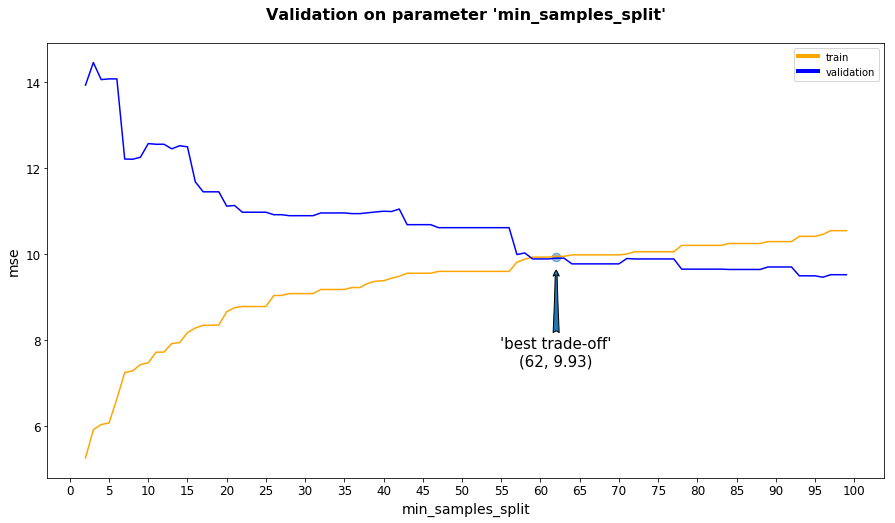

In [37]:
values_to_try = np.arange(2, 100)

mse_variation_train = []
mse_variation_val = []
for param_value in values_to_try:

    temp_params_dict = {
        'max_depth': 7,
        'min_samples_split': param_value,
        'random_state': RANDOM_STATE,
    }

    tree_mod = DecisionTreeRegressor(**temp_params_dict)
    tree_mod.fit(X_train_sub, y_train_sub)
    y_pred_train_sub = tree_mod.predict(X_train_sub)
    y_pred_val = tree_mod.predict(X_val)
    
    mse_variation_train.append(myUtils.mse(y_train_sub, y_pred_train_sub))
    mse_variation_val.append(myUtils.mse(y_val, y_pred_val))

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(values_to_try, mse_variation_train, color='orange')
ax.plot(values_to_try, mse_variation_val, color='blue')

custom_lines = [plt.Line2D([0], [0], color='orange', lw=4),
                plt.Line2D([0], [0], color='blue', lw=4)]
ax.legend(custom_lines, ['train', 'validation'])

ax.xaxis.set_ticks(list(map(int, np.arange(0, 101, 5))))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(14)
ax.xaxis.label.set_fontsize(14)
ax.xaxis.label.set_text('min_samples_split')
ax.yaxis.label.set_text('mse')
ax.title.set_text("Validation on parameter 'min_samples_split'\n")
ax.title.set_fontsize(16)
ax.title.set_fontweight('bold')

mse_distances = [abs(x - y) for x, y in zip(mse_variation_train, mse_variation_val)]
min_idx = myUtils.min_value_idx(mse_distances)
best_x, best_y = values_to_try[min_idx], (mse_variation_train[min_idx] + mse_variation_val[min_idx]) / 2

ax.scatter(best_x, best_y, marker='o', s=75, alpha=0.5)

ax.annotate(xy=(best_x, best_y - (abs(ax.axes.get_ylim()[1] - ax.axes.get_ylim()[0]) * 0.025)),
            xytext=(best_x, best_y - (abs(ax.axes.get_ylim()[1] - ax.axes.get_ylim()[0]) * 0.25)),
            s="'best trade-off'\n({0}, {1:.2f})".format(best_x, best_y),
            ha='center',
            size=15,
            arrowprops=dict(arrowstyle="fancy"))

# plt.savefig(str(PLOTS / "validation_on_parameter_min_samples_split_numeric_encode.png"), format='png')
plt.show()

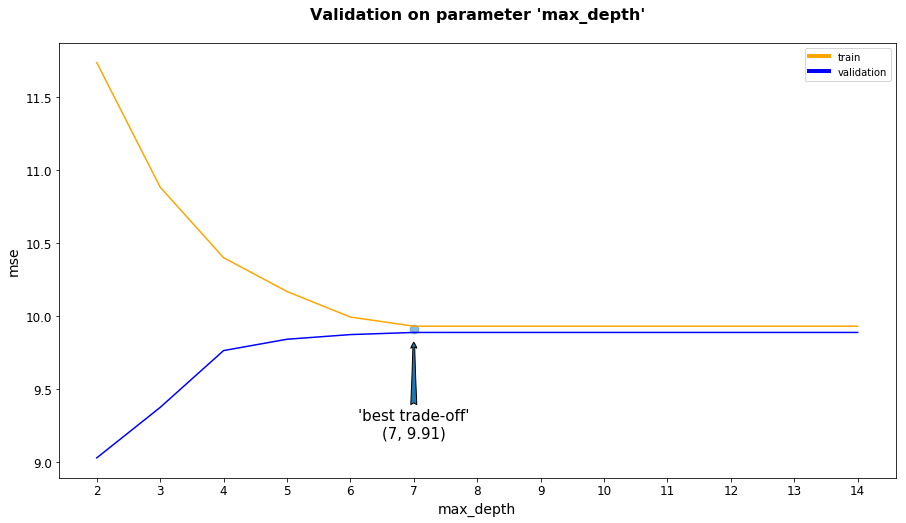

In [38]:
values_to_try = list(map(int, np.arange(2, 15)))

mse_variation_train = []
mse_variation_val = []
for param_value in values_to_try:

    temp_params_dict = {
        'max_depth': param_value,
        'min_samples_split': 60,
        'random_state': RANDOM_STATE,
    }

    tree_mod = DecisionTreeRegressor(**temp_params_dict)
    tree_mod.fit(X_train_sub, y_train_sub)
    y_pred_train_sub = tree_mod.predict(X_train_sub)
    y_pred_val = tree_mod.predict(X_val)
    
    mse_variation_train.append(myUtils.mse(y_train_sub, y_pred_train_sub))
    mse_variation_val.append(myUtils.mse(y_val, y_pred_val))

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(values_to_try, mse_variation_train, color='orange')
ax.plot(values_to_try, mse_variation_val, color='blue')
custom_lines = [plt.Line2D([0], [0], color='orange', lw=4),
                plt.Line2D([0], [0], color='blue', lw=4)]
ax.legend(custom_lines, ['train', 'validation'])
ax.xaxis.set_ticks(np.arange(2, 15))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(14)
ax.xaxis.label.set_fontsize(14)
ax.xaxis.label.set_text('max_depth')
ax.yaxis.label.set_text('mse')
ax.title.set_text("Validation on parameter 'max_depth'\n")
ax.title.set_fontsize(16)
ax.title.set_fontweight('bold')

mse_distances = [abs(x - y) for x, y in zip(mse_variation_train, mse_variation_val)]
min_idx = myUtils.min_value_idx(mse_distances)
best_x, best_y = values_to_try[min_idx], (mse_variation_train[min_idx] + mse_variation_val[min_idx]) / 2

ax.scatter(best_x, best_y, marker='o', s=75, alpha=0.5)

ax.annotate(xy=(best_x, best_y - (abs(ax.axes.get_ylim()[1] - ax.axes.get_ylim()[0]) * 0.025)),
            xytext=(best_x, best_y - (abs(ax.axes.get_ylim()[1] - ax.axes.get_ylim()[0]) * 0.25)),
            s="'best trade-off'\n({0}, {1:.2f})".format(best_x, best_y),
            ha='center',
            size=15,
            arrowprops=dict(arrowstyle="fancy"))

# plt.savefig(str(PLOTS / "validation_on_parameter_max_depth_numeric_encode.png"), format='png')
plt.show()

## 5.4 Fitting the Model
>**Now the Decision Tree can be fitted on the whole training set with the 'best trade-off' parameters found in the previous [previous](#5.3-Parameters-Validation) paragraph.**

In [39]:
tree_mod.fit(X_train, y_train)
print(">>> Decision Tree trained.")
y_pred_tree = tree_mod.predict(X_test)
print(">>> Predictions for the missing values of the variables 'Voto_Matematica' computed.")

>>> Decision Tree trained.
>>> Predictions for the missing values of the variables 'Voto_Matematica' computed.


>**Computing the prediction values of the variable 'Voto_Matematica' will be attached to the original dataset.**

In [40]:
data["Voto_Matematica"].loc[test_idx] = y_pred_tree
print(">>> Missing values of 'Voto_Matematica' handled.")

>>> Missing values of 'Voto_Matematica' handled.


In [41]:
# processed_numeric_encoded_fn = PROCESSED / "processed_numeric_encoded.csv"
# data.to_csv(processed_numeric_encoded_fn, index=None)
# print(">>> Processed dataset encoded with numeric encoding saved to path:\n", processed_numeric_encoded_fn)

In [42]:
# data = encoder.decode(drop=True)
# processed_decoded_fn = PROCESSED / "processed_decoded.csv"
# data.to_csv(processed_decoded_fn, index=None)
# print(">>> Processed dataset decoded saved to path:\n", processed_decoded_fn)

In [43]:
# data = encoder.one_hot_encode(drop=True)
# processed_one_hot_encoded_fn = PROCESSED / "processed_one_hot_encoded.csv"
# data.to_csv(processed_one_hot_encoded_fn, index=None)
# print(">>> Processed dataset encoded with One-Hot encoding saved to path:\n", processed_one_hot_encoded_fn)

In [44]:
# print(">>> Visualization of the Decision Tree model")
# data = pd.read_csv(PROCESSED / "processed_one_hot_encoded.csv")
# from graphviz import Source
# from sklearn.tree import export_graphviz
# from IPython.display import SVG

# graph = Source( export_graphviz(tree_mod, out_file=None, feature_names=data.drop(columns=["Voto_Matematica"]).columns))
# SVG(graph.pipe(format='svg'))

# 6. Interesting Remarks

In [45]:
data = encoder.decode(drop=True)
print(">>> Numeric encoded dataset decoded.")

>>> Numeric encoded dataset decoded.


In [46]:
display(data.groupby("Genere").mean().style.highlight_max())
print(">>> Average values of the other variables grouped by the variable 'Genere'.")
temp_density = data.Genere.value_counts(normalize=True).values
temp_density.shape += (1,)
temp_counts = data.Genere.value_counts().values
temp_counts.shape += (1,)
display(pd.DataFrame(np.concatenate((temp_counts, temp_density), axis=1), columns=["counts", "density"], index=["Male", "Female"]))

del temp_counts
del temp_density

>>> Average values of the other variables grouped by the variable 'Genere'.


counts   density
Male     836.0  0.689769
Female   376.0  0.310231

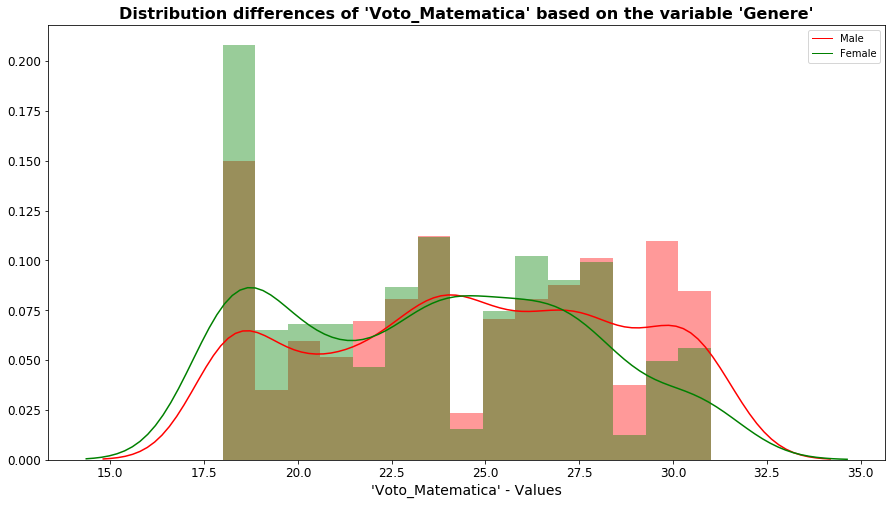

In [47]:
fig, ax = plt.subplots(figsize=(15, 8))
colors = ['red', 'green']

for value, color in zip(['M', 'F'], colors):
    crit1 = data['Genere'] == value
    crit2 = data['Voto_Matematica'] > 17
    sns.distplot(a=data[crit1 & crit2]['Voto_Matematica'], ax=ax, color=color, bins=15)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)

custom_lines = [plt.Line2D([0], [0], color=colors[0], lw=1),
                plt.Line2D([0], [0], color=colors[1], lw=1)]
ax.legend(custom_lines, ['Male', 'Female'])

ax.title.set_text("Distribution differences of 'Voto_Matematica' based on the variable 'Genere'")
ax.title.set_fontsize(16)
ax.title.set_fontweight('bold')

ax.xaxis.label.set_text("'Voto_Matematica' - Values")
ax.xaxis.label.set_fontsize(14)

# 
# plt.savefig(str(PLOTS / "Female_vs_Male_Voto_Matematica.png"), format='png')
plt.show()

In [48]:
display(data[['CdS', 'Voto_Matematica']].groupby('CdS').mean())
print(">>> Average values of the variable 'Voto_Matematica' grouped by the variable 'CdS'")

Voto_Matematica
CdS                  
CdS1        23.643134
CdS2        24.620901
CdS3        23.946756

>>> Average values of the variable 'Voto_Matematica' grouped by the variable 'CdS'


# 7. Clustering

>**The K-Means algorithm is applied to the dataset cleaned up in order to see if it can figure out some information regards the distribution of the data.**

In [49]:
data_ohe = encoder.one_hot_encode(drop=True)

>**Standardizating all columns by applying (x - mean(x)) / standardDeviation(x) to each variable of the dataset.**

In [50]:
sc = StandardScaler()
data_ohe_sc = sc.fit_transform(data_ohe)
print(">>> Dataset standardized columns-wise.")

>>> Dataset standardized columns-wise.


In [51]:
kmeans_params_dict = {
    'n_clusters': 3,
    'random_state': RANDOM_STATE,
    'n_jobs': None
}
kmeans_mod = KMeans(**kmeans_params_dict)
kmeans_mod.fit(data_ohe_sc)
kmeans_labels = kmeans_mod.labels_

In [52]:
data = data.join(pd.Series(kmeans_labels, name='KMEANS'))
print(">>> Labels made with K-Means cluster method attached to the dataset.")

>>> Labels made with K-Means cluster method attached to the dataset.


>**Three Clusters**

>**Visualization of the distributions of the numerical variables of the dataset based on three cluster founded with K-Means algorithm.**

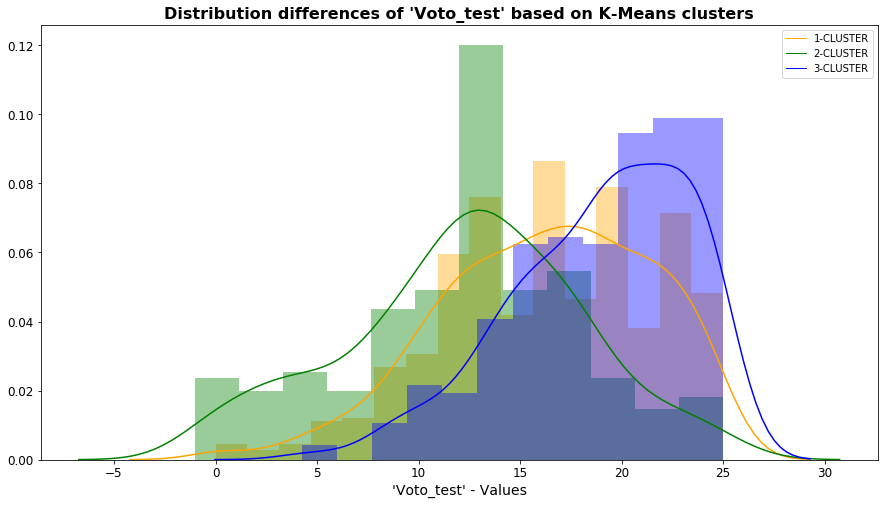

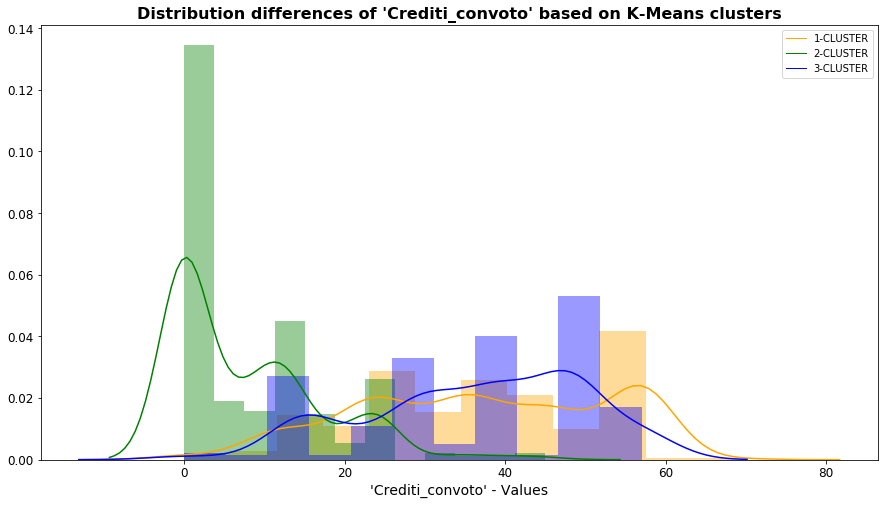

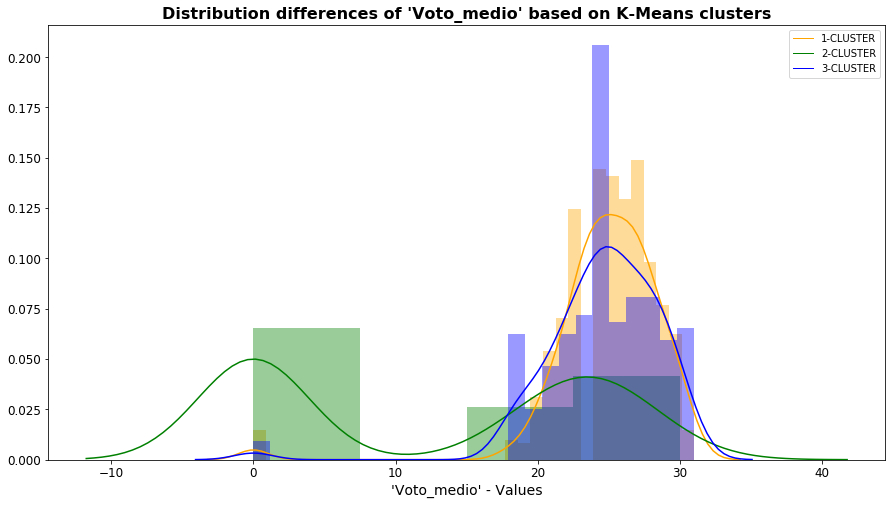

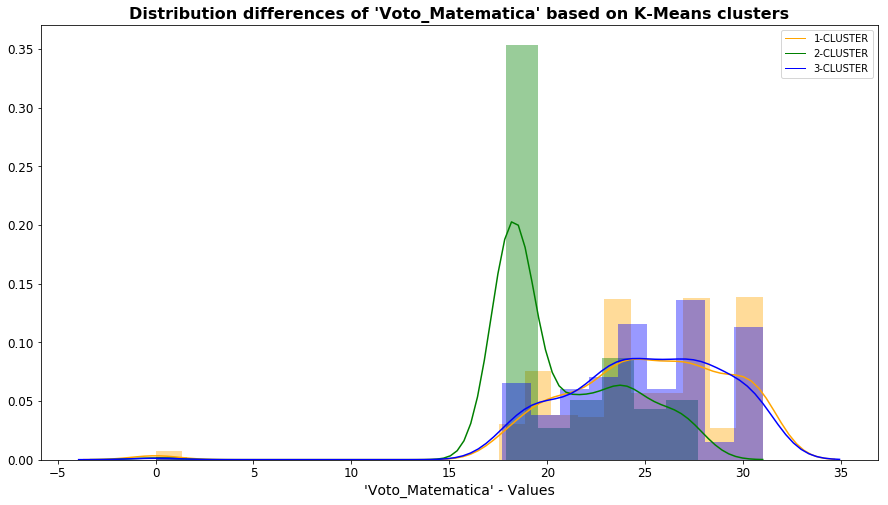

In [53]:
for var_name in data.drop(columns=['KMEANS']).select_dtypes('number').columns.tolist():
    series = data[var_name]
    labels = data['KMEANS']
    colors = ['orange', 'green', 'blue']

    fig, ax = plt.subplots(figsize=(15, 8))
    for value, color in zip(labels.unique().tolist(), colors):
        crit1 = labels == value
        sns.distplot(a=series[crit1], ax=ax, color=color)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)

    custom_lines = [plt.Line2D([0], [0], color=colors[0], lw=1),
                    plt.Line2D([0], [0], color=colors[1], lw=1),
                    plt.Line2D([0], [0], color=colors[2], lw=1)]
    ax.legend(custom_lines, ['1-CLUSTER', '2-CLUSTER', '3-CLUSTER'])

    ax.title.set_text("Distribution differences of '{0}' based on K-Means clusters".format(series.name))
    ax.title.set_fontsize(16)
    ax.title.set_fontweight('bold')

    ax.xaxis.label.set_text("'{0}' - Values".format(series.name))
    ax.xaxis.label.set_fontsize(14)

#     plt.savefig(str(PLOTS / "kmeans_3_clusters_vs_{0}.png".format(series.name)), format='png')
    plt.show()

>**Two Clusters**

>**Visualization of the distributions of the numerical variables of the dataset based on two clusters founded with K-Means algorithm.**

In [54]:
kmeans_params_dict = {
    'n_clusters': 2,
    'random_state': RANDOM_STATE,
    'n_jobs': None
}
kmeans_mod = KMeans(**kmeans_params_dict)
kmeans_mod.fit(data_ohe_sc)
kmeans_labels = kmeans_mod.labels_

if 'KMEANS' in data.columns.tolist():
    data.drop(columns=['KMEANS'], inplace=True)

data = data.join(pd.Series(kmeans_labels, name='KMEANS'))
print(">>> Labels made with K-Means cluster method attached to the dataset.")

>>> Labels made with K-Means cluster method attached to the dataset.


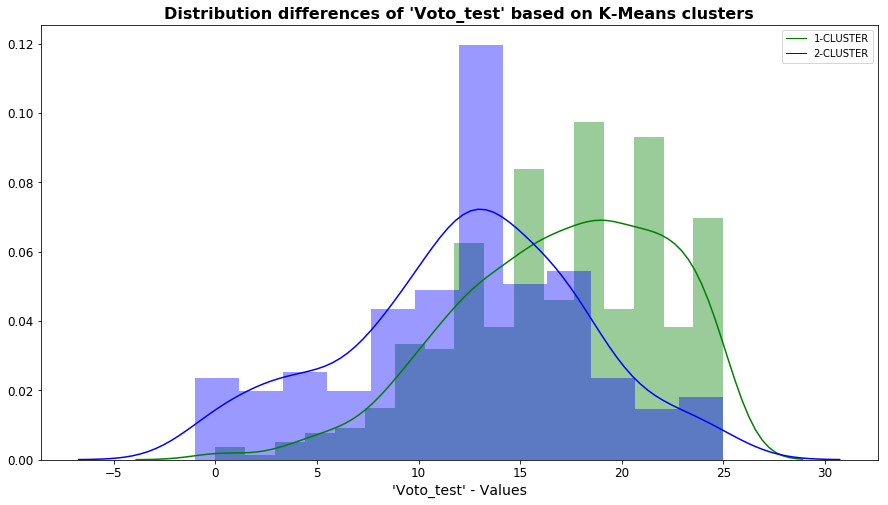

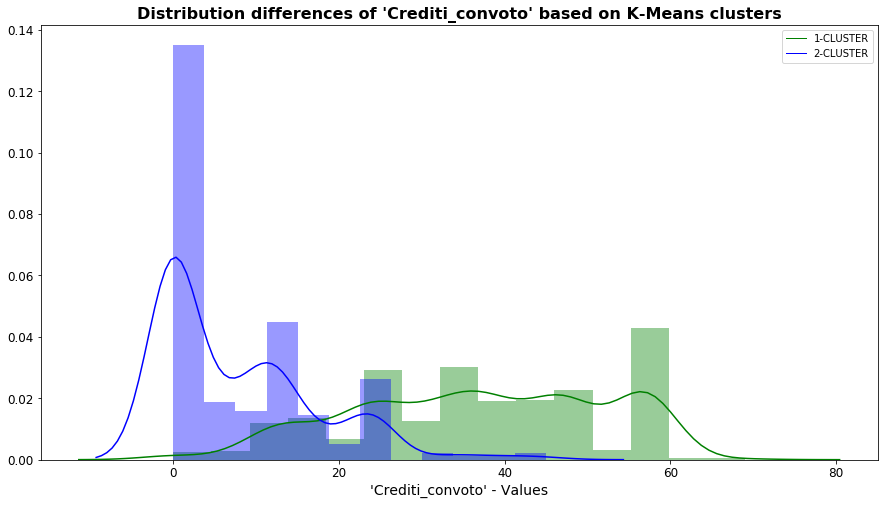

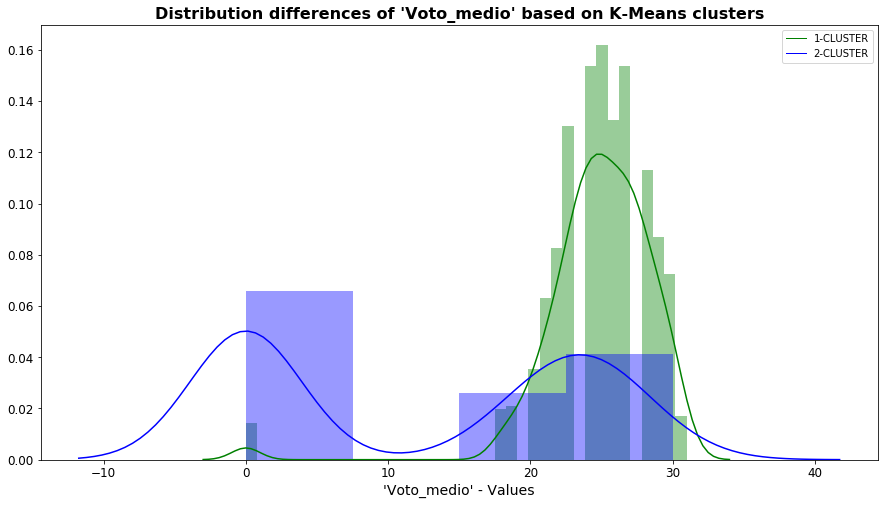

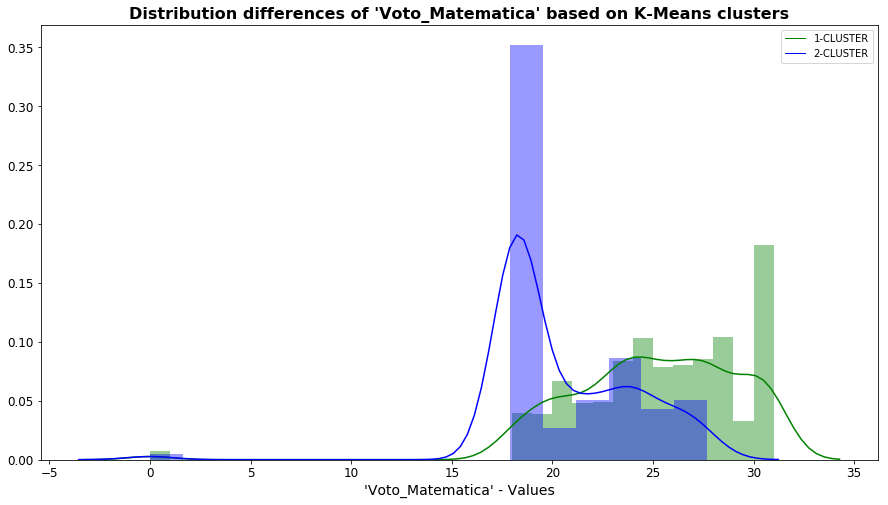

In [55]:
for var_name in data.drop(columns=['KMEANS']).select_dtypes('number').columns.tolist():
    series = data[var_name]
    labels = data['KMEANS']
    colors = ['green', 'blue']

    fig, ax = plt.subplots(figsize=(15, 8))
    for value, color in zip(labels.unique().tolist(), colors):
        crit1 = labels == value
        sns.distplot(a=series[crit1], ax=ax, color=color)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)

    custom_lines = [plt.Line2D([0], [0], color=colors[0], lw=1),
                    plt.Line2D([0], [0], color=colors[1], lw=1)]
    ax.legend(custom_lines, ['1-CLUSTER', '2-CLUSTER'])

    ax.title.set_text("Distribution differences of '{0}' based on K-Means clusters".format(series.name))
    ax.title.set_fontsize(16)
    ax.title.set_fontweight('bold')

    ax.xaxis.label.set_text("'{0}' - Values".format(series.name))
    ax.xaxis.label.set_fontsize(14)

#     plt.savefig(str(PLOTS / "kmeans_2_clusters_vs_{0}.png".format(series.name)), format='png')
    plt.show()

>**With only two clusters the differences in the distributions of the variables are more clear.**

# 8. Feedforward Neural Network

>**Application of a feedforward neural network model with the package [QuickNN](<https://gitlab.com/deeplego/quicknn>).**

In [56]:
# X_train_sub = pd.read_csv(INTERIM / 'X_train_sub.csv')
# y_train_sub = pd.read_csv(INTERIM / 'y_train_sub.csv')
# X_val = pd.read_csv(INTERIM / 'X_val.csv')
# y_val = pd.read_csv(INTERIM / 'y_val.csv')

In [57]:
# X_train = pd.read_csv(INTERIM / 'X_train.csv')
# y_train = pd.read_csv(INTERIM / 'y_train.csv')
# X_test = pd.read_csv(INTERIM / 'X_test.csv')

In [58]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)

In [59]:
nn = QuickNN(list_neurons=[300, 200, 1], training_func=tf.train.AdamOptimizer)
nn_params_dict = {
    'batch_size': 32,
    'n_epochs': 125,
    'learning_rate': 0.015,  # 0.015 > 0.01
    'validation': True,
    'test_size': 0.30,
    'list_dropout_rate': [0.1, 0.1, 0.1]
}

In [60]:
nn.fit(X_train_sc, y_train, **nn_params_dict)

Epoch: 1 | training_loss: 19987.209 | validation_loss: 14736.232
Epoch: 2 | training_loss: 10596.069 | validation_loss: 5632.0225
Epoch: 3 | training_loss: 5235.0146 | validation_loss: 2201.2
Epoch: 4 | training_loss: 4360.9565 | validation_loss: 1970.072
Epoch: 5 | training_loss: 3075.2017 | validation_loss: 1099.0912
Epoch: 6 | training_loss: 2430.3738 | validation_loss: 1044.6522
Epoch: 7 | training_loss: 2344.2715 | validation_loss: 719.1203
Epoch: 8 | training_loss: 1704.8265 | validation_loss: 500.47568
Epoch: 9 | training_loss: 1386.3737 | validation_loss: 516.1238
Epoch: 10 | training_loss: 1118.8062 | validation_loss: 390.2251
Epoch: 11 | training_loss: 1046.8602 | validation_loss: 289.85703
Epoch: 12 | training_loss: 799.9654 | validation_loss: 219.0418
Epoch: 13 | training_loss: 700.3827 | validation_loss: 182.49825
Epoch: 14 | training_loss: 584.30725 | validation_loss: 148.88185
Epoch: 15 | training_loss: 464.13223 | validation_loss: 136.04994
Epoch: 16 | training_loss: 45

In [61]:
print('                      ' + '| NUMERIC ENCODING | ONE-HOT ENCODING')
print('----------------------+------------------+-----------------')
print("Tree - MSE - train set|  9.947           |  9.9089")
print('----------------------+------------------+-----------------')
print("Tree - MSE - val set  |  9.9051          | 10.0484")
print('----------------------+------------------+-----------------')
print("NN   - MSE - train set| 20.5970          | 42.566566")
print('----------------------+------------------+-----------------')
print("NN   - MSE - val set  | 19.5581          | 21.032434")

                      | NUMERIC ENCODING | ONE-HOT ENCODING
----------------------+------------------+-----------------
Tree - MSE - train set|  9.947           |  9.9089
----------------------+------------------+-----------------
Tree - MSE - val set  |  9.9051          | 10.0484
----------------------+------------------+-----------------
NN   - MSE - train set| 20.5970          | 42.566566
----------------------+------------------+-----------------
NN   - MSE - val set  | 19.5581          | 21.032434


>**From the results above figure out that the Decision Tree is much better to predict the missing values of the variables 'Voto_Matemaitca' with this type of dataset, instead of a neural network. This can depends on the amount of the data (too low for a neural network) otherwise can be a shallow parameters validation on the network.**

In [62]:
nn = QuickNN(list_neurons=[300, 200, 1], training_func=tf.train.AdamOptimizer)
nn_params_dict = {
    'batch_size': 32,
    'n_epochs': 125,
    'learning_rate': 0.015,  # 0.015 > 0.01
    'list_dropout_rate': [0.1, 0.1, 0.1]
}

In [63]:
nn.fit(X_train_sc, y_train, **nn_params_dict)

Epoch: 1 | loss: 24025.19
Epoch: 2 | loss: 10874.633
Epoch: 3 | loss: 4930.0386
Epoch: 4 | loss: 3585.177
Epoch: 5 | loss: 2040.0928
Epoch: 6 | loss: 1728.4294
Epoch: 7 | loss: 1429.7303
Epoch: 8 | loss: 1033.277
Epoch: 9 | loss: 759.7815
Epoch: 10 | loss: 665.59064
Epoch: 11 | loss: 567.9822
Epoch: 12 | loss: 499.0938
Epoch: 13 | loss: 365.60214
Epoch: 14 | loss: 336.39316
Epoch: 15 | loss: 295.47095
Epoch: 16 | loss: 221.39668
Epoch: 17 | loss: 213.23438
Epoch: 18 | loss: 169.90002
Epoch: 19 | loss: 171.10028
Epoch: 20 | loss: 132.66235
Epoch: 21 | loss: 142.5933
Epoch: 22 | loss: 130.6144
Epoch: 23 | loss: 126.226776
Epoch: 24 | loss: 92.7478
Epoch: 25 | loss: 101.94715
Epoch: 26 | loss: 89.95127
Epoch: 27 | loss: 87.051735
Epoch: 28 | loss: 81.82619
Epoch: 29 | loss: 76.48079
Epoch: 30 | loss: 68.01073
Epoch: 31 | loss: 58.64719
Epoch: 32 | loss: 57.9705
Epoch: 33 | loss: 61.970203
Epoch: 34 | loss: 60.126278
Epoch: 35 | loss: 48.379696
Epoch: 36 | loss: 52.20416
Epoch: 37 | loss: 

In [64]:
y_pred_nn = nn.predict(X_test_sc)

INFO:tensorflow:Restoring parameters from /home/lore/.local/share/quicknn/tf_saver/qnn/qnn-3625


In [65]:
data = pd.read_csv(INTERIM / 'preEncoding.csv')
data["Voto_Matematica"].loc[test_idx] = y_pred_nn
# data.to_csv(PROCESSED / 'processed_nn_decoded.csv', index=None)

In [66]:
data.head()

CdS  Coorte Genere  Voto_test  Crediti_convoto  Voto_medio  \
0  CdS1    2010      M       22.0               27          24   
1  CdS1    2010      M       17.0                9          24   
2  CdS1    2010      F       13.0               21          20   
3  CdS1    2010      F       19.0               39          26   
4  CdS1    2010      F       17.0               45          23   

  Scuola_provenienza Esame_Matematica  Voto_Matematica Crediti_Matematica  
0                 LC  EsameMatematica             20.0               12.0  
1                 LS  EsameMatematica             20.0               12.0  
2                 LS  EsameMatematica             25.0               12.0  
3                 LS  EsameMatematica             30.0               12.0  
4                 TC  EsameMatematica             24.0               12.0